In [1]:
import os
import warnings
import time
from copy import deepcopy

import numpy as np 

from scipy.stats import chisquare
from scipy.interpolate import interp1d, interp2d

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve, Gaussian2DKernel
from astropy import units as u 
from astropy.nddata import CCDData, Cutout2D
from astropy.wcs.utils import proj_plane_pixel_scales

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties, SourceProperties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus
from photutils.isophote import EllipseGeometry, Ellipse

In [2]:
from lcbg.utils import cutout, measure_fwhm, pixel_to_angular, angular_to_pixel, natural_sort, plot_target, closest_value_index, get_interpolated_values
from lcbg.fitting import print_model_params, plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D, model_to_image
from lcbg.segmentation import get_source_e, get_source_ellip, get_source_theta, plot_segment_residual, plot_segments, make_segments, get_source_position, deblend_segments, segm_mask, masked_segm_image
from lcbg.photometry import flux_to_abmag, order_cat, calculate_photometic_density, plot_apertures, radial_elliptical_aperture, radial_elliptical_annulus, plot_apertures
from lcbg.cosmology import cosmo_aperture_diameter
from lcbg.petrosian import calculate_petrosian, calculate_petrosian_r, calculate_r_half_light, calculate_r_total_flux, plot_petrosian

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [5]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [6]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Load Data

In this notebook we use a single filter frontier field of Abell 2744 to develop the steps necessary to compute the Petrosian radius of individual galaxies. We download the data from the STScI archive using AstroPy.

In [7]:
current_filter =  filter_list[0]
input_data_path = input_data_formatter.format(current_filter)
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

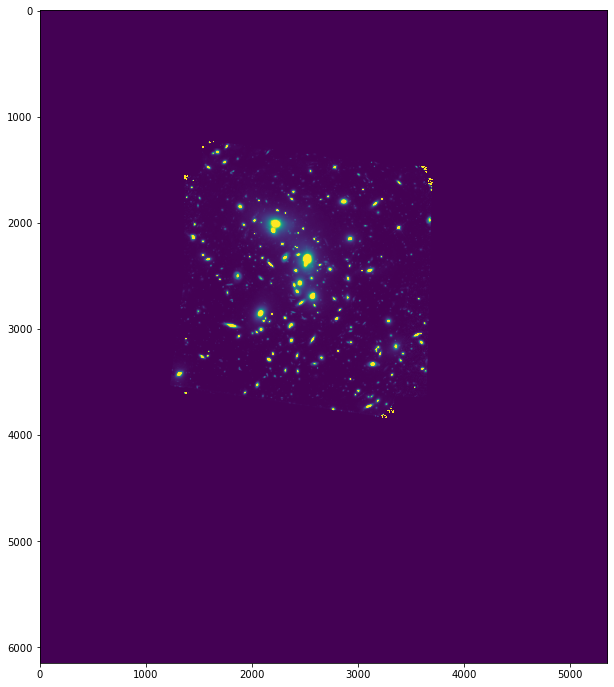

In [8]:
# Load data and vitals
# ---------------------
data = CCDData.read(input_data_path)

plt.imshow(data, vmin=0, vmax=data.data.mean()*10)

#  Estimate Data Noise

In this section we check if the noise is gaussian by sampling a dark region (making a cutout) and doing some statics on the pixels.

-0.00012860226 0.0038543560076504946 0.010278282687067986


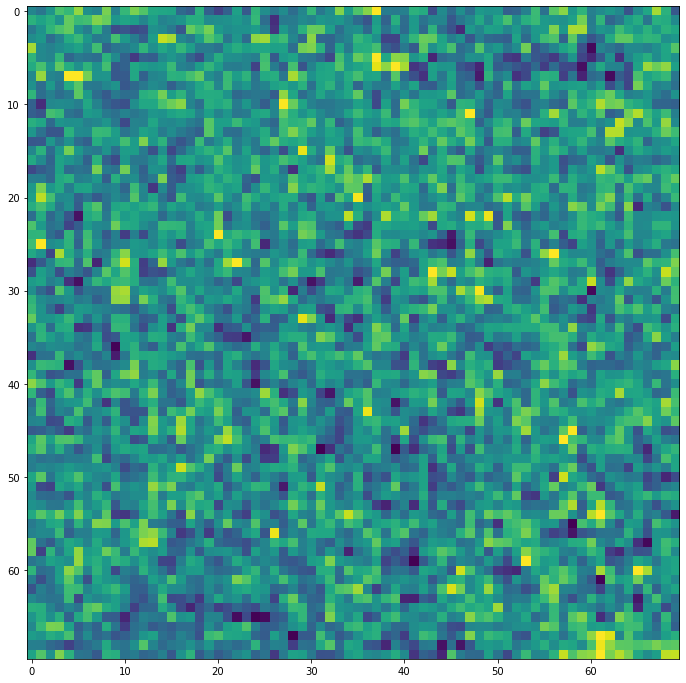

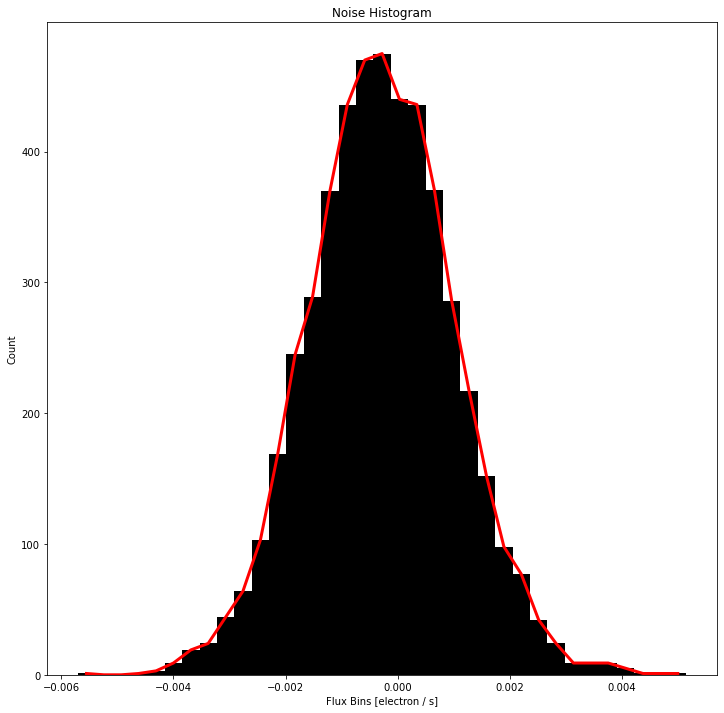

In [9]:
# Estimate data noise at dark area
# --------------------------------
noise_cutout = Cutout2D(data, (2760, 3420), 70)

noise_mean = noise_cutout.data.mean()
noise_sigma = noise_cutout.data.std()
noise_3_sigma = noise_sigma * 3.
noise_8_sigma = noise_sigma * 8.

print(noise_mean, noise_3_sigma, noise_8_sigma)

plt.imshow(noise_cutout.data, vmax=noise_mean+noise_3_sigma, vmin=noise_mean-noise_3_sigma)
plt.show()

n, bins, patches = plt.hist(noise_cutout.data.flatten(), bins=35, align='left', color='black')
plt.plot(bins[:-1], n, c='r', linewidth=3)

plt.xlabel('Flux Bins [{}]'.format(str(data.unit)))
plt.ylabel('Count')
plt.title('Noise Histogram')
plt.show()


# Make Cutout Image of Targets

Since the data is large, we make a cutout image to analyze. I have picked out a few different targets and they can used by un-commenting their coordinates below.

0.01989697


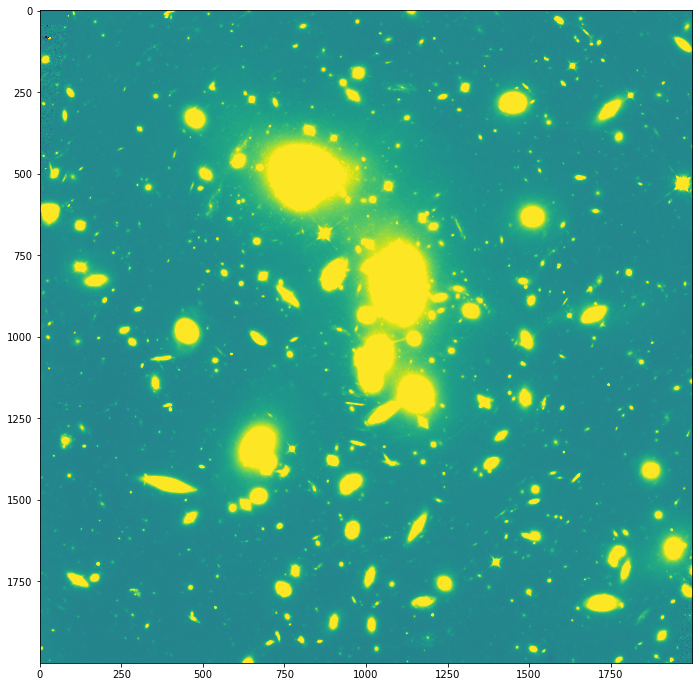

In [10]:
# Cutout Image
# -------------

# Select and crop image:

# Center of cluster:
cx, cy = [int(np.round(i)) for i in data.wcs.world_to_pixel_values(data.header["RA_TARG"], data.header["DEC_TARG"])]
size = 2000

# Cutom center:
#cx, cy, size = 2864, 3563, 100 # Small faint group of galaxies
#cx, cy, size = 2340, 3180, 780 # Larger group of galaxies
#cx, cy, size = 2390, 3000, 1000 # Large slice of the sky 
#cx, cy, size = 1738, 1434, 150 # Single Bright galaxy 
#cx, cy, size = 2083, 2859, 300 # Lone CD galaxy
#cx, cy, size = 2458, 2756, 150 # Spiral face on 
#cx, cy, size = 2308, 2333, 300 # Spiral face on 2
#cx, cy, size = 2400, 3320, 600 # Default group of galaxies
#cx, cy, size = 3379, 2050, 101 # star

image = Cutout2D(data, (cx, cy), size, copy=True)

# Compute image stats
image_min = image.data.min()
image_max = image.data.max()
image_mean = image.data.mean()
image_sigma = image.data.std()
image_3_sigma = image_sigma * 3.
image_8_sigma = image_sigma * 8.

image_clipped_mean, image_clipped_median, image_clipped_std = sigma_clipped_stats(image.data, sigma=3.0)

# Subtract Noise
image.data  -= image_clipped_mean

# Set min and max values for all plots
vmin = -10 * image_clipped_std
vmax = +10 * image_clipped_std

plt.imshow(image.data, vmin=vmin, vmax=vmax)

print(image_mean)

# Make Segmentation Map and Source Catalog

Here we make a segmentation map and deblend the segmented objects. We detect objects above the detection level which is set by nsigma (times the std). We also define the size of the smoothing kernel used for the segmentation and deblending. After the deblending, we make a catalog of sources. 

Num of Targets: 250


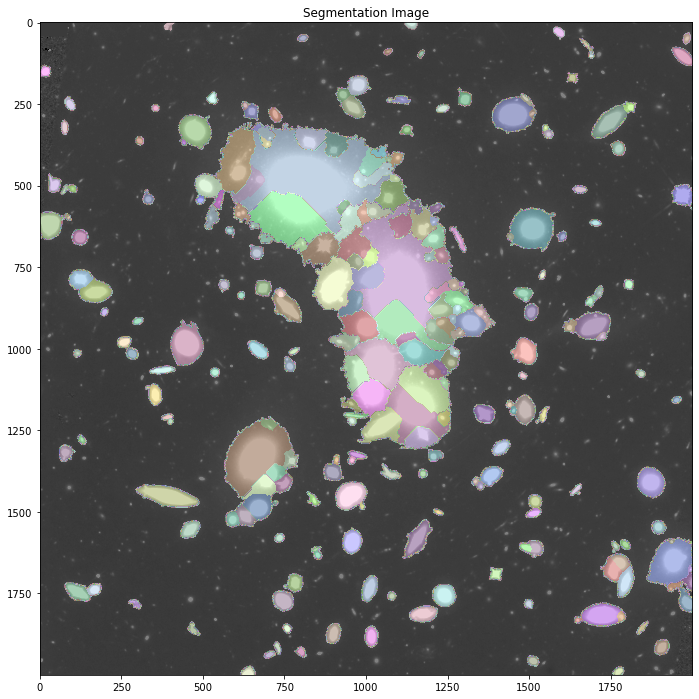

In [11]:
# Catalog
# -------

# Define detect threshold
nsigma = 3

# Define smoothing kernel
kernel_size = 10

# Make segmentation map
segm = make_segments(image.data, nsigma=nsigma, kernel_size=kernel_size, fwhm=5, npixels=20**2)

# Deblend segmentation map
segm_deblend = deblend_segments(image.data, segm, contrast=0, kernel_size=kernel_size, fwhm=5, npixels=10**2)

# Remove border sources
#segm_deblend.remove_border_labels(1)

# Make catalog
cat = source_properties(image.data, segm_deblend, wcs=image.wcs)

# Display source properties
print("Num of Targets:", len(cat))

# Plot segments
plot_segments(segm_deblend, image.data, vmin=vmin, vmax=vmax)
plt.show()

### Inspect the segmented sources by unmasking the target one at a time

In [12]:
# Test out masked_segm_image
def slider(x):
    obj = cat[x]
    
    position = get_source_position(obj)
    e = get_source_e(obj)
    theta = get_source_theta(obj)
    r = obj.equivalent_radius.value * 1.5
    
    plt.imshow(masked_segm_image(obj, image, segm_deblend).data, vmin=vmin, vmax=vmax)
    aperture = radial_elliptical_aperture(position, r, e, theta)
    aperture.plot(plt.gca(), color='r', linewidth=2)
    
    
    plt.show()

widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=249), Output()), _dom_classes=('widget-inte…

# Define Aperture Radii

Here we define a list of radii for the apertures to be used in photometry. Since the apertures are likely elliptical, we will use these values are the semi-major radius. We expect the wings of an LCBG to be within 14 * arcsecs so we define the max radius to be as such.  

In [13]:
galaxy_pixel_size = angular_to_pixel(14 * u.arcsec, wcs=image.wcs) # convert to pixels
galaxy_pixel_size

233.33337659191358

In [14]:
# List of radii
# -------------

n = 50
max_pix = galaxy_pixel_size 
r_list = [x * int(max_pix/n) for x in range(1, n+1)]
r_list = np.array(r_list)

print("max=", r_list[-1])
print("len=", len(r_list))

max= 200
len= 50


# Photometry

### Define photometry functions

In [15]:
def photometry_step(position, r_list, image, e=1., theta=0., annulus_r=None, annulus_dr=5,
                    subtract_bg=True, return_areas=False, bg_density=None,
                    plot=False, vmin=0, vmax=None):

    # Estimate background
    annulus = None
    if subtract_bg and bg_density is None:
        annulus_r = annulus_r if annulus_r else max(r_list)
        annulus = radial_elliptical_annulus(position, annulus_r, annulus_dr, e=e, theta=theta)
        bg_density = annulus.do_photometry(image.data)[0][0] / annulus.area
        bg_density = np.round(bg_density, 6)

    aperture_photometry_row = []
    aperture_area_row = []

    if plot:
        plt.imshow(image.data, vmin=vmin, vmax=image.data.mean()*10 if vmax is None else vmax)
        
    for i, r in enumerate(r_list):

        aperture = radial_elliptical_aperture(position, r, e=e, theta=theta)
        aperture_area = np.round(aperture.area, 6)

        photometric_sum = aperture.do_photometry(image.data)[0][0]

        photometric_value = np.round(photometric_sum, 6)

        if np.isnan(photometric_value):
            raise Exception("Nan photometric_value")

        if subtract_bg:
            photometric_bkg =  np.round(aperture_area * bg_density, 6)
            photometric_value -= photometric_bkg
            
        if plot:
            aperture.plot(plt.gca(), color='w', alpha=0.5)

        aperture_photometry_row.append(photometric_value)
        aperture_area_row.append(aperture_area)

    if plot and annulus is not None:
        annulus.plot(plt.gca(), color='r', linestyle='--', alpha=0.5)

    if return_areas:
        return aperture_photometry_row, aperture_area_row
    else:
        return aperture_photometry_row

In [16]:
def object_photometry(obj, image, segm_deblend, mean_sub=False, plot=False):
    if plot:
        print(obj.id)
        fig, ax = plt.subplots(1, 2, figsize=[24,12])
    
    position = get_source_position(obj)
    e = get_source_e(obj)
    theta = get_source_theta(obj)
    
    cutout_size = max(r_list)*3
    
    # Estimate mean in coutuout
    masked_nan_image = masked_segm_image(obj, image, segm_deblend, fill=np.nan)
    masked_nan_image = Cutout2D(masked_nan_image.data, position, cutout_size, mode='partial', fill_value=np.nan)
    mean, median, std = sigma_clipped_stats(masked_nan_image.data, sigma=2.0, mask=np.isnan(masked_nan_image.data) )
    
    # Make coutuout
    masked_image = masked_nan_image.data 
    if mean_sub:
        masked_image -= mean
    
    # Convert nan values to mean 
    idx = np.where(np.isnan(masked_image))
    masked_image[idx] = 0 #np.random.normal(0., std, len(idx[0]))
    
    position = np.array(masked_image.data.shape) / 2.

    if plot:
        plt.sca(ax[0])
    aperture_photometry_row , a_list= photometry_step(position, r_list, masked_image, e=e, theta=theta, return_areas=True, 
                                                      plot=plot, vmin=vmin, vmax=vmax, subtract_bg=False)
    
    if plot:
        plt.sca(ax[1])
        plt.plot(r_list, aperture_photometry_row, c='black', linewidth=3)
        for r in r_list:
            plt.axvline(r, alpha=0.5, c='r')
        plt.show()
        
        
        
        r = max(r_list)
        fig, ax = plt.subplots(1, 1, figsize=[24,6])
        plt.plot(masked_image[:, int(position[0])], c='black', linewidth=3)
        plt.axhline(0, c='black')
        #plt.axhline(noise_sigma, c='b')
        plt.axvline(position[0], linestyle='--')
        plt.axvline(position[0]+r, alpha=0.5, c='r')
        plt.axvline(position[0]-r, alpha=0.5, c='r')
        plt.xlabel("Slice Along Y [pix]")
        plt.ylabel("Flux")

                        
        fig, ax = plt.subplots(1, 1, figsize=[24,6])

        plt.plot(masked_image[int(position[1]), :], c='black', linewidth=3)
        plt.axhline(0, c='black')
        #plt.axhline(noise_sigma, c='b')
        plt.axvline(position[0], linestyle='--')
        plt.axvline(position[0]+r, alpha=0.5, c='r')
        plt.axvline(position[0]-r, alpha=0.5, c='r')
        plt.xlabel("Slice Along X [pix]")
        plt.ylabel("Flux")
        
    return aperture_photometry_row , a_list

### Test photometry function on one target at time

In [17]:
# Test photometry function
def slider(x):
    x = order_cat(cat)[x]
    obj = cat[x]
    f, a = object_photometry(obj, image, segm_deblend, mean_sub=True, plot=True)
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=249), Output()), _dom_classes=('widget-inte…

### Do photomerty on all objects in the source catalog and save to file

In [18]:
# Photomerty
# ----------
pb = widgets.IntProgress(
    value=0,
    min=0,
    max=len(cat),
    step=1,
    description='Loading:',
    bar_style='',
    orientation='horizontal'
)
display(pb)

single_aperture_photometry_table = cat.to_table()

aperture_photometry_rows = []
aperture_area_rows = []
for idx, obj in enumerate(cat):
    pb.value = idx + 1
    pb.description = "{}/{}".format(pb.value, len(cat))
    
    aperture_photometry_row, aperture_area_row = object_photometry(obj, image, segm_deblend, mean_sub=True)
    
    aperture_photometry_rows.append(np.array(aperture_photometry_row))
    aperture_area_rows.append(aperture_area_row)
    
single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.add_columns(np.transpose(aperture_area_rows), names=["aperture_area_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
plt.show()

IntProgress(value=0, description='Loading:', max=250)

# Load Photometry Results

In [19]:
result_cat = Table.read(output_path)
result_cat.sort(keys="source_sum", reverse=1)
result_cat

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,aperture_sum_004,aperture_sum_112,aperture_sum_116,aperture_sum_120,aperture_sum_124,aperture_sum_128,aperture_sum_132,aperture_sum_136,aperture_sum_140,aperture_sum_144,aperture_sum_148,aperture_sum_152,aperture_sum_156,aperture_sum_160,aperture_sum_164,aperture_sum_168,aperture_sum_172,aperture_sum_176,aperture_sum_180,aperture_sum_184,aperture_sum_188,aperture_sum_192,aperture_sum_108,aperture_sum_104,aperture_sum_100,aperture_sum_096,aperture_sum_008,aperture_sum_012,aperture_sum_016,aperture_sum_020,aperture_sum_024,aperture_sum_028,aperture_sum_032,aperture_sum_036,aperture_sum_040,aperture_sum_044,aperture_sum_196,aperture_sum_048,aperture_sum_056,aperture_sum_060,aperture_sum_064,aperture_sum_068,aperture_sum_072,aperture_sum_076,aperture_sum_080,aperture_sum_084,aperture_sum_088,aperture_sum_092,aperture_sum_052,aperture_sum_200,aperture_area_004,aperture_area_112,aperture_area_116,aperture_area_120,aperture_area_124,aperture_area_128,aperture_area_132,aperture_area_136,aperture_area_140,aperture_area_144,aperture_area_148,aperture_area_152,aperture_area_156,aperture_area_160,aperture_area_164,aperture_area_168,aperture_area_172,aperture_area_176,aperture_area_180,aperture_area_184,aperture_area_188,aperture_area_192,aperture_area_108,aperture_area_104,aperture_area_100,aperture_area_096,aperture_area_008,aperture_area_012,aperture_area_016,aperture_area_020,aperture_area_024,aperture_area_028,aperture_area_032,aperture_area_036,aperture_area_040,aperture_area_044,aperture_area_196,aperture_area_048,aperture_area_056,aperture_area_060,aperture_area_064,aperture_area_068,aperture_area_072,aperture_area_076,aperture_area_080,aperture_area_084,aperture_area_088,aperture_area_092,aperture_area_052,aperture_area_200
int64,float64,float64,str38,str38,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
119,816.3091250627452,487.3404676640102,"3.591880657137708,-30.405802328587928","3.5918776264674865,-30.405804505089776",6089.4976,None,None,None,None,612.0,1072.0,310.0,648.0,0.0032149935,7.0511527,766.0,327.0,809.0,492.0,66126.0,145.08121702615173,2209.859269334294,60.78120677180421,37.0808227280656,14.846948162970628,0.7923471174131183,0.3899294749562784,1.6391547517040486,3542.0703900328317,574.4680976021938,1527.2721207942122,0.00030066236152205534,-0.0002261822663983938,0.0006973002608014706,0.6486426088560001,178.41228,4813.352817,4884.500948,4953.06739,5019.532415,5082.50419,5142.590499,5197.579477,5248.587025,5297.180202,5343.488755,5387.954594,5430.750274,5472.014547,5511.069097,5547.365506,5580.439697,5610.070304,5635.617093,5658.594244,5678

The cell below creates a list of column names used to index the result catalog. For example to get a list of area:

```
index = 0 # any row index
area_list = result_cat[index][area_col_names]
```

In [20]:
mag_col_names = natural_sort([i for i in result_cat.colnames if "aperture_sum_" in i])
area_col_names = natural_sort([i for i in result_cat.colnames if "aperture_area_" in i])

# Calculate Petrosian

In [21]:
def slider(x):
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(image.data, vmin=vmin, vmax=vmax)
    ax[0,0].set_xlim(x-size, x+size)
    ax[0,0].set_ylim(y-size, y+size)
    ax[0,0].set_title("Target {}".format(row['id']))
    
    ax[0,1].imshow(masked_image.data, vmin=vmin, vmax=vmax)
    ax[0,1].set_xlim(x-size, x+size)
    ax[0,1].set_ylim(y-size, y+size)
    ax[0,1].set_title("Target [Masked Image]")    
    
    position = [x, y]
    
    for r in r_list:
        aperture = radial_elliptical_aperture(position, r, e=obj_e, theta=obj_theta)
        aperture.plot(ax[0,0], color='r', alpha=0.5)
        aperture.plot(ax[0,1], color='r', alpha=0.5)


    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = list(row[mag_col_names])
    ax[1,0].plot(r_list, y_values, label="Raw")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = calculate_photometic_density(r_list, flux_list, e=obj_e, theta=obj_theta)
    ax[1,1].plot(r_list, y_values, label="Raw") 
  
    ax[1,1].set_title("Photometic Density: sum(slice) / area(slice)")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Density")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    # Petrosian
    # ---------
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=249), Output()), _dom_classes=('widget-inte…

# Inspect r_half_light and r_total_flux

In [22]:
def slider(x):
    
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    fig, ax = plt.subplots(1, 2, figsize=[12,6])
    
    plt.sca(ax[0])
    plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    plt.title("Target {}".format(row['id']))
    
    # Calculate petrosian
    # -------------------
    petrosian_number = 0.2
    r_petrosian = calculate_petrosian_r(r_list, area_list, flux_list, eta=petrosian_number)
    if r_petrosian is None:
        print("r_petrosian could not be computed")
        return
    
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=petrosian_number)
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=petrosian_number)
    
    
    # r_half_light and r_total_flux Plots
    # -----------------------------------
    size = int(r_total_flux * 1.5)
    position = [x, y]
    
    # r_total_flux 
    aperture = radial_elliptical_aperture(position, r_total_flux, e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    
    # r_half_light
    if r_half_light is None:
        print("r_half_light could not be computed")
    else:
        aperture = radial_elliptical_aperture(position, r_half_light, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle="--", label='R Half Light')
    
    plt.xlim(x-size, x+size)
    plt.ylim(y-size, y+size)
    
    plt.legend()
    
    plt.sca(ax[1])
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));


interactive(children=(BoundedIntText(value=0, description='x', max=249), Output()), _dom_classes=('widget-inte…

# Concentration Index Functions 

In [23]:
from lcbg.petrosian import fraction_flux_to_r
def calculate_concentration_index(r_list, area_list, flux_list, ratio1=0.2, ratio2=0.8, eta=0.2):
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=eta)

    if r_total_flux > max(r_list):
        return None

    r_list_new, flux_list_new = get_interpolated_values(r_list, flux_list)

    f = interp1d(r_list, flux_list, kind='cubic')
    total_flux = f(r_total_flux)
    
    r1 = fraction_flux_to_r(r_list, area_list, flux_list, fraction=ratio1, eta=eta)
    r2 = fraction_flux_to_r(r_list, area_list, flux_list, fraction=ratio2, eta=eta)

    if None in [r1, r2]:
        return None
    
    return r1, r2, 5 * np.log10(r2/r1)

In [24]:
def estimate_n(c2080pet):
    n_list = [0.5, 0.75, 1, 1.5, 2, 4, 6, 8]
    c_pet_list = [2.14, 2.49, 2.78, 3.26, 3.63, 4.50, 4.99, 5.31]
    f = interp1d(c_pet_list, n_list, kind='cubic')
    try:
        return f(c2080pet)
    except ValueError:
        print("Could not estimate n for {}, returning closest".format(c2080pet))
        return 0.5 if c2080pet < 2.14 else 5.31

# Final Summary 

In [29]:
def slider(x):
    
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    fig, ax = plt.subplots(1, 2, figsize=[12,6])
    
    plt.sca(ax[0])
    plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    plt.title("Target {}".format(row['id']))
    
    # Calculate petrosian
    # -------------------
    petrosian_number = 0.2
    r_petrosian = calculate_petrosian_r(r_list, area_list, flux_list, eta=petrosian_number)
    if r_petrosian is None:
        print("r_petrosian could not be computed")
        return
    
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=petrosian_number)
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=petrosian_number)
    result = calculate_concentration_index(r_list, area_list, flux_list, eta=petrosian_number, ratio1=0.2, ratio2=0.8)
    if result is None:
        print("concentration_index could not be computed")
        return 
    r1, r2, c2080 = result
    

    f = interp1d(r_list, flux_list)
    f_half_light = flux_to_abmag(f(r_half_light), data.header)
    f_total = flux_to_abmag(f(r_total_flux), data.header)
    print(" ")
    print("R_half_light: angular = {:0.2f}\tpix = {:0.2f} pix\tmag = {:0.2f}".format(pixel_to_angular(r_half_light, image.wcs), r_half_light, f_half_light))
    print("R_total_flux: angular = {:0.2f}\tpix = {:0.2f} pix\tmag = {:0.2f}".format(pixel_to_angular(r_total_flux, image.wcs), r_total_flux, f_total))
    print("Concentration Index: r_20={:0.2f} r_80={:0.2f} C2080={:0.2f} n_estimate={:0.2f}".format(r1, r2, c2080, estimate_n(c2080)))

    
    # r_half_light and r_total_flux Plots
    # -----------------------------------
    size = int(r_total_flux * 1.5)
    position = [x, y]
    
    # r_total_flux 
    aperture = radial_elliptical_aperture(position, r_total_flux, e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    
    # r_half_light
    if None in [r_half_light, r1, r2]:
        print("Could not be computed")
    else:
        aperture = radial_elliptical_aperture(position, r_half_light, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle="-", label='R Half Light')
        aperture = radial_elliptical_aperture(position, r1, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle=':', label='R_20')
        aperture = radial_elliptical_aperture(position, r2, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle=':', label='R_80')
    
    plt.xlim(x-size, x+size)
    plt.ylim(y-size, y+size)
    
    plt.legend()
    
    plt.sca(ax[1])
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));



interactive(children=(BoundedIntText(value=0, description='x', max=249), Output()), _dom_classes=('widget-inte…

# Fit Sersic Model and Compare Cumulative Photometries

Now that we have the half-light radius and the concentration index (which gives a Sersic index), we attempt to fit a model to the targets and measure the model half-light radius as a sanity check. Furthermore, this opens an investigation into the possibility of using these models to remove bright sources in an effort to reduce the noise in the images. At this moment the profile only uses a combo of two sersic models and a Moffat for the PSF. Cluter CD clusters need many sersic profiles to fit as discussed in [GalFit](https://users.obs.carnegiescience.edu/peng/work/galfit/distant.html), notice how most (even simple looking galaxies) need 3 or more profiles plus a PSF profile. In the future we will need to add code that can estimate the needed amount of profiles to properly fit galaxies. 

For now we use the function below to check if low flux galaxies' `r_petrosian` matches the fitted `r_petrosian_model`. Since we are only using two Sersics, please fit dim galaxies for best results (the galaxies are ordered by brighness so you can index to a higher number).

In [26]:
def fit_sersic(image, x, y, r_1, r_2=None, sersic_n=3.0, ellip=0, theta=0, xy_slack=0, mask_slack=0, plot=False):
    if mask_slack is not None:
        image[int(y)-mask_slack:int(y)+mask_slack, int(x)-mask_slack:int(y)+mask_slack] = np.nan
        
    image = np.ma.masked_array(image, mask=np.isnan(image))
    
    
    g = EllipseGeometry(x, y, 1., ellip, theta)
    g.find_center(image)
    ellipse = Ellipse(image, geometry=g)
    
    iso_1 = ellipse.fit_isophote(r_1)
    
    model_1 = models.Sersic2D(
        amplitude=iso_1.intens,
        n=sersic_n,
        r_eff=r_1,    
        ellip=iso_1.eps,
        theta=iso_1.pa,
        x_0=x,
        y_0=y,
        fixed={'ellip':True,'theta':True,},
        bounds={
            'amplitude': (0, None),
            'r_eff': (0, None),
            'n': (0, 7),
            'ellip': (0, 1),
            'theta': (0, 2 * np.pi),
            'x_0': (x - xy_slack, x + xy_slack),
            'y_0': (y - xy_slack, y + xy_slack),
        })
    
    
    model_psf = Moffat2D(
                amplitude=image.max(), 
                x_0=model_1.x_0, 
                y_0=model_1.y_0,
                bounds={
                    'amplitude': (0, None),
                    'x_0': (x - xy_slack, x + xy_slack),
                    'y_0': (y - xy_slack, y + xy_slack),
                }
    )

    model = model_1 + model_psf
    
    iso_2 = None 
    if r_2:
        try:
            model, fit = fit_model(image, model, maxiter=1000000, epsilon=0)

            iso_2 = ellipse.fit_isophote(r_2)
            model_2 = models.Sersic2D(
                amplitude=0,
                n=1,
                r_eff=r_2,
                ellip=iso_2.eps,
                theta=iso_2.pa,
                x_0=iso_2.x0,
                y_0=iso_2.y0,
                bounds={
                    'amplitude': (0, image.max()),
                    'r_eff': (0, None),
                    'n': (1, 1),
                    'ellip': (0, 1),
                    'theta': (0, 2 * np.pi),
                    'x_0': (iso_2.x0-xy_slack, iso_2.x0+xy_slack),
                    'y_0': (iso_2.y0-xy_slack, iso_2.y0+xy_slack),
                })


            model =  model + model_2 
        except:
            print("Could not get isophote at r_2")
            pass
    

    model, fit = fit_model(image, model, maxiter=1000000, epsilon=0)
    model.x_0 = model_1.x_0
    model.y_0 = model_1.y_0
    
    if plot:
        model_image = 0#model_to_image(model.x_0.value, model.y_0.value, image.shape[0], model)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image, vmin=vmin, vmax=vmax*10)
        ax.set_title("Fitted Target")

        ax.plot(x, y, '+', c='r', label='Target')

        # go to the outermost successfully fitted ellipse at sma=235
        isos = []
        x, y, = iso_1.sampled_coordinates()
        ax.plot(x, y, color='r')

        if r_2 and iso_2:
            x, y, = iso_2.sampled_coordinates()
            ax.plot(x, y, color='r')
    #print_model_params(modddel)
    return model, fit

In [31]:
def slider(x):
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))

    obj_e = row['elongation']
    obj_ellip = row['ellipticity']
    obj_theta = np.deg2rad(row['orientation']) 

    masked_image = masked_segm_image(row['id'], image, segm_deblend, fill=0)

    size = max(r_list)
    x, y = get_source_position(row)

    # Plot Target
    # -----------
    plt.figure(figsize=[2, 2])
    plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    plt.title("Target {}".format(row['id']))
    plt.show()

    # Calculate r_half_light
    # -------------------
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=0.2)
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=0.2)
    if r_half_light is None:
        print('Could not calculate r_half_light')
        return 

    # Make Cutout to fit
    # ------------------
    cutout_size = round(r_total_flux) * 3.
    if cutout_size % 2 != 0:
        cutout_size += 1

    # Estimate mean in coutuout
    target_zoom_nan_image = masked_segm_image(row['id'], image, segm_deblend, fill=np.nan, mask_background=False)
    target_zoom_nan_image = Cutout2D(target_zoom_nan_image.data, (x, y), cutout_size, mode='partial', fill_value=np.nan)
    mean, median, std = sigma_clipped_stats(target_zoom_nan_image.data, sigma=1.0, 
                                            mask=np.isnan(target_zoom_nan_image.data) 
                                           )

    # Make coutuout
    target_zoom = target_zoom_nan_image.data - median 

    # Convert nan values to mean 
    idx = np.where(np.isnan(target_zoom))
    target_zoom[idx] = np.nan #np.random.normal(0., std, len(idx[0]))
    target_x, target_y = np.array(target_zoom.data.shape) / 2.
    
    # Make models to fit
    # ------------------
    result = calculate_concentration_index(r_list, area_list, flux_list, eta=0.2, ratio1=0.2, ratio2=0.8)
    if result is None:
        print("Could not compute c2080")
        return
    r20, r80, c2080 = result
    print('r_half_light=', r_half_light)
    print('c2080=', c2080)
    print('n_estimate=',estimate_n(c2080))
    
    model, fit = fit_sersic(target_zoom, target_x, target_y, r_half_light, r_2=r80, plot=True,
                            sersic_n=estimate_n(c2080), ellip=obj_ellip, theta=obj_theta, xy_slack=5, mask_slack=0)
    

    # Compute model photometry
    # ------------------------
    target_zoom[idx] = 0
    model_image = model_to_image(model.x_0.value, model.y_0.value, max(r_list)*2, model)
    model_fluxs, model_area_list = photometry_step(np.array(model_image.shape)/2, r_list, model_image,
                                                   e=obj_e, theta=obj_theta,
                                                   plot=False, subtract_bg=False, vmax=vmax/2, 
                                                   return_areas=True)

    # Compute model petrosian_r
    # -------------------------
    r_petrosian_model = calculate_petrosian_r(r_list, model_area_list, model_fluxs)
    if not r_petrosian_model:
        r_petrosian_model = 0.0
    print(" ")
    print("r_petrosian_data = {:0.2f}\tr_petrosian_model = {:0.2f}".format(
        calculate_petrosian_r(r_list, area_list, flux_list),
        r_petrosian_model
        )
    )
    
    plt.show()
    
    # Plots 
    # -----
    model_image = model_to_image(model.x_0.value, model.y_0.value, cutout_size, model)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(model_image, vmin=vmin, vmax=vmax*10)
    
    plt.show()

    plt.plot(r_list, flux_list, label="Data", marker='o', c='black', linestyle='--')
    plt.plot(r_list, model_fluxs, label="Model", c='r')

    plt.legend()
    plt.show()

    # Plot fit
    fig, ax = plot_fit(target_zoom, model, vmin=image_clipped_std * - 5, vmax=image_clipped_std*5)

    plt.show()
    
    #fig, ax = plt.subplots(2, 1)
    #plt.sca(ax[0])
    model_image = model_to_image(model.x_0.value, model.y_0.value, cutout_size, model)
    diff = target_zoom - model_image
    idx_x, idx_y = int(round(target_x)), int(round(target_y))
    plt.title("X Slice")
    plt.plot(diff[:,idx_x], label='Difference')
    plt.plot(model_image[:,idx_x], label="model_image", linewidth=2.0, c='r')
    plt.plot(target_zoom[:,idx_x], label="Data", marker='o', alpha=0.5, c='black', linestyle='--')
    plt.legend()
    
    plt.xlabel('Pixels')
    plt.ylabel('Flux [{}]'.format(str(data.unit)))
    
    plt.show()
    #plt.sca(ax[1])
    plt.title("Y Slice")
    plt.plot(diff[idx_y,:], label='Difference')
    plt.plot(model_image[idx_y,:], label="model_image", linewidth=2.0, c='r')
    plt.plot(target_zoom[idx_y,:], label="Data", marker='o', alpha=0.5, c='black', linestyle='--')
    plt.legend()
    
    plt.xlabel('Pixels')
    plt.ylabel('Flux [{}]'.format(str(data.unit)))
    plt.show()
    
    tco = Cutout2D(image.data, (x, y), cutout_size, mode='partial', fill_value=np.nan).data
    plt.imshow(tco - model_image, vmin=image_clipped_std * - 5, vmax=image_clipped_std*5)
    plt.show()
    
    
style = """
    <style>
       .jupyter-widgets-output-area .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
        .jupyter-widgets-output-area  {
            height: auto !important;
        }
    </style>
    """
display(widgets.HTML(style))
wd = widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1))

HTML(value='\n    <style>\n       .jupyter-widgets-output-area .output_scroll {\n            height: unset !im…

interactive(children=(BoundedIntText(value=0, description='x', max=249), Output()), _dom_classes=('widget-inte…